System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 8 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 6 on 6 virtual cores


Load packages:

In [2]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, LoopVectorization
using Profile, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an alternative to principal components and vector quantization with applications in data compression, clustering, and deconvolution. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates the iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

#### Q1.1 Solution:

In [3]:
function nnmf(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    # implementation
    ## initialization and preallocation
    obj0, obj, niter = 0.0, 1.0, 0
    m, n = size(X)
    XWt = Array{Float64}(undef, m, r)
    VtX = Array{Float64}(undef, r, n)
    WWt = W * transpose(W)
    VtV = Array{Float64}(undef, r, r)
    VWWt = Array{Float64}(undef, m, r)
    VtVW = Array{Float64}(undef, r, n)
    trXtX = norm(X, 2)^2
    WtVtX = Array{Float64}(undef, n, n)
    WWtVtV = Array{Float64}(undef, r, r)
    
    ## main loop
    while (abs(obj - obj0)) / (abs(obj0 + 1)) >= tolfun && niter < maxiter
        # update V
        mul!(XWt, X, transpose(W))
        mul!(VWWt, V, WWt) # WWt was updated later in the loop
        V .= V .* XWt ./ VWWt
        # update W
        mul!(VtX, transpose(V), X)
        mul!(VtV, transpose(V), V)
        mul!(VtVW, VtV, W)
        W .= W .* VtX ./ VtVW
        # update niter and obj
        obj0 = obj
        mul!(WWt, W, transpose(W))
        mul!(WtVtX, transpose(W), VtX)
        mul!(WWtVtV, WWt, VtV)
        obj = trXtX - 2 * tr(WtVtX) + tr(WWtVtV)
        niter += 1
    end
    
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu/software-datasets/FaceData2.html) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple of sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

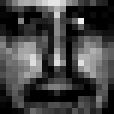

In [4]:
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

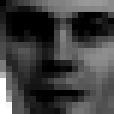

In [5]:
colorview(Gray, reshape(X[10, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@btime`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2023spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64);

# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!(V0, V0full[:, 1:r]), 
        copyto!(W0, W0full[1:r, :])
        )
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  162.662 ms (9 allocations: 437.19 KiB)
obj=11730.866905748058, niter=239
r=20
  234.293 ms (9 allocations: 875.44 KiB)
obj=8497.605595863002, niter=394
r=30
  259.524 ms (9 allocations: 1.28 MiB)
obj=6621.94596847528, niter=482
r=40
  289.918 ms (9 allocations: 1.72 MiB)
obj=5256.866299829562, niter=581
r=50
  397.511 ms (10 allocations: 2.15 MiB)
obj=4430.362097310877, niter=698
```
Due to machine differences, your run times can be different from mine but certainly can not be order of magnitude longer. Your memory allocation should be less or equal to mine.

#### Q1.3 Solution:

In [6]:
# provided start point
V0full = readdlm("V0.txt", ' ', Float64)
W0full = readdlm("W0.txt", ' ', Float64)
println("Initial V0 and W0 are loaded!")

Initial V0 and W0 are loaded!


In [7]:
# benchmarking
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    _, _, obj, niter = nnmf(X, r, V = V0, W = W0)
    @btime nnmf($X, $r, V = $V0, W = $W0) setup=(
        copyto!($V0, $V0full[:, 1:$r]), 
        copyto!($W0, $W0full[1:$r, :])
        )
    println("obj=$obj, niter=$niter")
end

r=10


  222.447 ms (13 allocations: 1.42 MiB)
obj=11730.388009852482, niter=239
r=20


  543.636 ms (13 allocations: 1.86 MiB)
obj=8497.222317847947, niter=394
r=30


  1.070 s (13 allocations: 2.29 MiB)
obj=6621.627345483881, niter=482
r=40


  1.417 s (13 allocations: 2.73 MiB)
obj=5256.663870561242, niter=581
r=50


  1.873 s (16 allocations: 3.18 MiB)
obj=4430.201581695044, niter=698


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

#### Q1.4 solution:
Choose r = 10 and compare the results from the previous and another random initial $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$:

In [8]:
# 1. results from given start point
r = 10
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V1, W1, obj1, niter1 = nnmf(X, r, V = V0, W = W0)
println("obj=$obj1, niter=$niter1")

obj=11730.388009852482, niter=239


In [9]:
# 2. results from a random start point
using Random
Random.seed!(257)
V2, W2, obj2, niter2 = nnmf(X, r)
println("obj=$obj2, niter=$niter2")

obj=11664.751247646724, niter=225


In [10]:
# comparing the V and W
println("V1 == V2: ", V1 == V2, ", W1 == W2: ", W1 == W2)

V1 == V2: false, W1 == W2: false


See above, the results ($\mathbf{V}$ and $\mathbf{W}$, the objective function, and the number of iterations) were different if we used a different initial $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. This means the algorithm is not unique (not guaranteed to converge to a unique solution). 

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

#### Q1.5 solution:

In [11]:
# create the matrice V0 and W0 with all entries equal to 1
V0 = ones(size(X, 1), r)
W0 = ones(r, size(X, 2))
V3, W3, obj3, niter3 = nnmf(X, r, V = V0, W = W0)
println("obj=$obj3, niter=$niter3")

obj=25297.01651107958, niter=3


In [12]:
# comparing the V and W
println("V1 == V3: ", V1 == V3, ", W1 == W3: ", W1 == W3)

V1 == V3: false, W1 == W3: false


We did not achieve the same result as the given initial $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. The objective function of this part is larger (`obj = 25297`) compared to the objective function in the last part. The number of iterations is small (`niter = 3`), which hints that the algorithm was trapped in a local minimum and did not converge to the global minimum. 

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

#### Q1.6 solution:

In [13]:
r = 50
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V, W, _, _ = nnmf(X, r, V = V0, W = W0)
println("NNMF is done!")

NNMF is done!


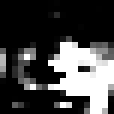

In [14]:
colorview(Gray, reshape(W[1, :], 19, 19))

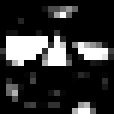

In [15]:
colorview(Gray, reshape(W[2, :], 19, 19))

The contrast of the image is higher than original image. Actually these images in $\mathbb{W}$ matrix are capturing the "features" of human faces. So, it looks like parts of human faces. 

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

#### Q1.7 solution:
The machine I use is a Macbook Pro with M1 pro (Apple silicon). Due to the better support for single precision floating point operations, I used `Float32` instead of `Float64` in the GPU function `nnmfgpu`. Also, I reconstruct a new `nnmfsp` function for CPU with single precision to make a fair comparison.

In [16]:
using Metal
Metal.versioninfo()

macOS 13.3.1, Darwin 21.5.0

Toolchain:
- Julia: 1.8.5
- LLVM: 13.0.1

1 device:
- Apple M1 Pro (64.000 KiB allocated)


In [17]:
# write a function with single precision for GPU
function nnmfgpu(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 0.0001f0,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    # implementation
    ## initialization and preallocation
    obj0, obj, niter = 0.0f0, 1.0f0, 0
    m, n = size(X)
    XWt = MtlArray{Float32}(undef, m, r)
    VtX = MtlArray{Float32}(undef, r, n)
    WWt = W * transpose(W)
    VtV = MtlArray{Float32}(undef, r, r)
    VWWt = MtlArray{Float32}(undef, m, r)
    VtVW = MtlArray{Float32}(undef, r, n)
    trXtX = norm(X, 2)^2
    WtVtX = MtlArray{Float32}(undef, n, n)
    WWtVtV = MtlArray{Float32}(undef, r, r)
    
    ## main loop
    while (abs(obj - obj0)) / (abs(obj0 + 1)) >= tolfun && niter < maxiter
        # update V
        mul!(XWt, X, transpose(W))
        mul!(VWWt, V, WWt) # WWt was updated later in the loop
        V .= V .* XWt ./ VWWt
        # update W
        mul!(VtX, transpose(V), X)
        mul!(VtV, transpose(V), V)
        mul!(VtVW, VtV, W)
        W .= W .* VtX ./ VtVW
        # update niter and obj
        obj0 = obj
        mul!(WWt, W, transpose(W))
        mul!(WtVtX, transpose(W), VtX)
        mul!(WWtVtV, WWt, VtV)
        obj = trXtX - 2 * tr(WtVtX) + tr(WWtVtV)
        niter += 1
    end
    
    # Output
    V, W, obj, niter
end

nnmfgpu (generic function with 1 method)

In [18]:
# write a function with single precision for CPU to compare
function nnmfsp(
    # positional arguments
    X       :: AbstractMatrix{T}, 
    r       :: Integer;
    # kw arguments
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 0.0001f0,
    V       :: AbstractMatrix{T} = Random.rand!(similar(X, size(X, 1), r)),
    W       :: AbstractMatrix{T} = Random.rand!(similar(X, r, size(X, 2))),
    ) where T <: AbstractFloat
    # implementation
    ## initialization and preallocation
    obj0, obj, niter = 0.0f0, 1.0f0, 0
    m, n = size(X)
    XWt = Array{Float32}(undef, m, r)
    VtX = Array{Float32}(undef, r, n)
    WWt = W * transpose(W)
    VtV = Array{Float32}(undef, r, r)
    VWWt = Array{Float32}(undef, m, r)
    VtVW = Array{Float32}(undef, r, n)
    trXtX = norm(X, 2)^2
    WtVtX = Array{Float32}(undef, n, n)
    WWtVtV = Array{Float32}(undef, r, r)
    
    ## main loop
    while (abs(obj - obj0)) / (abs(obj0 + 1)) >= tolfun && niter < maxiter
        # update V
        mul!(XWt, X, transpose(W))
        mul!(VWWt, V, WWt) # WWt was updated later in the loop
        V .= V .* XWt ./ VWWt
        # update W
        mul!(VtX, transpose(V), X)
        mul!(VtV, transpose(V), V)
        mul!(VtVW, VtV, W)
        W .= W .* VtX ./ VtVW
        # update niter and obj
        obj0 = obj
        mul!(WWt, W, transpose(W))
        mul!(WtVtX, transpose(W), VtX)
        mul!(WWtVtV, WWt, VtV)
        obj = trXtX - 2 * tr(WtVtX) + tr(WWtVtV)
        niter += 1
    end
    
    # Output
    V, W, obj, niter
end

nnmfsp (generic function with 1 method)

In [20]:
# convert X as single precision matrix and transfer to GPU
Xsp = convert(Array{Float32}, X)
Xd = MtlArray(Xsp)
# benchmark on GPU
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    V0sp = convert(Array{Float32}, V0)
    W0sp = convert(Array{Float32}, W0)
    V0d = MtlArray(V0sp)
    W0d = MtlArray(W0sp)
    println("GPU performance: ")
    @btime nnmfgpu($Xd, $r, V = $V0d, W = $W0d) 
    println("CPU performance (single precision): ")
    @btime nnmfsp($Xsp, $r, V = $V0sp, W = $W0sp) 
    println("CPU performance (double precision): ")
    @btime nnmf($X, $r, V = $V0, W = $W0) 
end
print("FINISH")

r=10
GPU performance: 


  11.532 ms

 (9349 allocations: 215.52 KiB)
CPU performance (single precision): 


  3.046 ms (11 allocations: 729.09 KiB)
CPU performance (double precision): 


  3.343 ms (13 allocations: 1.42 MiB)
r=20
GPU performance: 


  10.436 ms

 (9358 allocations: 215.66 KiB)
CPU performance (single precision): 


  3.859 ms (13 allocations: 950.78 KiB)
CPU performance (double precision): 


  4.314 ms (13 allocations: 1.86 MiB)
r=30
GPU performance: 


  15.610 ms

 (9368 allocations: 215.82 KiB)
CPU performance (single precision): 


  4.299 ms (13 allocations: 1.15 MiB)
CPU performance (double precision): 


  5.548 ms (13 allocations: 2.29 MiB)
r=40
GPU performance: 


  16.618 ms

 (9368 allocations: 215.82 KiB)
CPU performance (single precision): 


  4.995 ms (13 allocations: 1.37 MiB)
CPU performance (double precision): 


  6.052 ms (13 allocations: 2.73 MiB)
r=50
GPU performance: 


  20.469 ms

 (9368 allocations: 215.82 KiB)
CPU performance (single precision): 


  4.779 ms (13 allocations: 1.59 MiB)
CPU performance (double precision): 


  6.574 ms (16 allocations: 3.18 MiB)
FINISH

In [21]:
# extra benchmark to compare the performance of GPU and CPU when r=10
V0 = V0full[:, 1:10]
W0 = W0full[1:10, :]
V0sp = convert(Array{Float32}, V0)
W0sp = convert(Array{Float32}, W0)
V0d = MtlArray(V0sp)
W0d = MtlArray(W0sp)
@benchmark nnmfgpu($Xd, 10, V = $V0d, W = $W0d) 

BenchmarkTools.Trial: 306 samples with 1 evaluation.
 Range (min … max):   8.531 ms … 18.654 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.682 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.338 ms ±  1.618 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                 ▂▆█ ▅▆ ▁      
  ▃▃▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▂▁▁▄▂▄▃▃▃▃▄▆▆▄▆█▇█████████▅▄▆▄ ▃
  8.53 ms         Histogram: frequency by time        18.3 ms <

 Memory estimate: 215.52 KiB, allocs estimate: 9349.

In [22]:
@benchmark Metal.@sync nnmfgpu($Xd, 10, V = $V0d, W = $W0d) 

BenchmarkTools.Trial: 312 samples with 1 evaluation.
 Range (min … max):   8.614 ms … 25.080 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.648 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.019 ms ±  2.188 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                      ▄ ▂██▃▆█▃                
  ▂▅▁▁▁▃▂▂▁▂▃▂▄▄▂▃▂▃▁▃▁▃▂▂▁▄▄▄▄▄▅▆▇▆▆▇█▇███████▆▄▄▂▁▁▁▁▁▁▂▁▁▂ ▄
  8.61 ms         Histogram: frequency by time        20.7 ms <

 Memory estimate: 215.87 KiB, allocs estimate: 9366.

In [23]:
@benchmark nnmfsp($Xsp, 10, V = $V0sp, W = $W0sp)

BenchmarkTools.Trial: 1443 samples with 1 evaluation.
 Range (min … max):  3.062 ms … 27.829 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.171 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.464 ms ±  1.389 ms  ┊ GC (mean ± σ):  0.98% ± 4.71%

  █▆▄▂▂▁                                                      
  ███████▇▇▇▇▅▇▅▄▆▅▅▅▅▆▅▅▃▃▃▅▃▁▁▃▁▄▃▁▁▃▁▁▁▁▁▃▁▃▁▃▄▁▃▃▁▁▁▁▁▁▄ █
  3.06 ms      Histogram: log(frequency) by time     9.68 ms <

 Memory estimate: 729.09 KiB, allocs estimate: 11.

In [24]:
@benchmark nnmf($X, 10, V = $V0, W = $W0)

BenchmarkTools.Trial: 1206 samples with 1 evaluation.
 Range (min … max):  3.307 ms … 35.178 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.674 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.143 ms ±  1.868 ms  ┊ GC (mean ± σ):  1.31% ± 5.68%

  ▂▇█▅▄▂▁                                                     
  ███████▇▇▅▇▇▆█▅▆▆▅▆▅▆▅▄▅▅▅▄▄▄▅▄▄▄▄▄▅▁▄▄▁▅▄▁▄▅▁▄▄▅▁▁▄▁▁▁▄▄▄ █
  3.31 ms      Histogram: log(frequency) by time     12.4 ms <

 Memory estimate: 1.42 MiB, allocs estimate: 13.